In [1]:
import numpy as np
import tensorflow as tf
from datasets import audio
from wavenet_vocoder.util import is_mulaw, is_mulaw_quantize, mulaw, mulaw_quantize
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
# Default hyperparameters
hparams = tf.contrib.training.HParams(
    # Comma-separated list of cleaners to run on text prior to training and eval. For non-English

    num_mels = 80, #Number of mel-spectrogram channels and local conditioning dimensionality

    num_freq = 2049, # (= n_fft / 2 + 1) only used when adding linear spectrograms post processing network
    rescale = True, #Whether to rescale audio prior to preprocessing
    rescaling_max = 0.999, #Rescaling value
    trim_silence = True, #Whether to clip silence in Audio (at beginning and end of audio only, not the middle)
    #train samples of lengths between 3sec and 14sec are more than enough to make a model capable of good parallelization.
    clip_mels_length = False, #For cases of OOM (Not really recommended, only use if facing unsolvable OOM errors, also consider clipping your samples to smaller chunks)
    max_mel_frames = 1000,  #Only relevant when clip_mels_length = True, please only use after trying output_per_steps=3 and still getting OOM errors.

    # Use LWS (https://github.com/Jonathan-LeRoux/lws) for STFT and phase reconstruction
    # It's preferred to set True to use with https://github.com/r9y9/wavenet_vocoder
    # Does not work if n_ffit is not multiple of hop_size!!
    use_lws=True,
    silence_threshold=2, #silence threshold used for sound trimming for wavenet preprocessing

    #Mel spectrogram
    n_fft = 4096, #Extra window size is filled with 0 paddings to match this parameter
    hop_size = 128, #For 22050Hz, 275 ~= 12.5 ms
    win_size = 512, #For 22050Hz, 1100 ~= 50 ms (If None, win_size = n_fft)
    sample_rate = 22050, #22050 Hz (corresponding to ljspeech dataset)
    frame_shift_ms = None,

    #M-AILABS (and other datasets) trim params (there parameters are usually correct for any data, but definitely must be tuned for specific speakers)
    trim_fft_size = 512, 
    trim_hop_size = 128,
    trim_top_db = 23,

    #Mel and Linear spectrograms normalization/scaling and clipping
    signal_normalization = True, #Whether to normalize mel spectrograms to some predefined range (following below parameters)
    allow_clipping_in_normalization = True, #Only relevant if mel_normalization = True
    symmetric_mels = True, #Whether to scale the data to be symmetric around 0. (Also multiplies the output range by 2, faster and cleaner convergence)
    max_abs_value = 4., #max absolute value of data. If symmetric, data will be [-max, max] else [0, max] (Must not be too big to avoid gradient explosion, 
                                                                                                          #not too small for fast convergence)
    normalize_for_wavenet = True, #whether to rescale to [0, 1] for wavenet. (better audio quality)
    clip_for_wavenet = True, #whether to clip [-max, max] before training/synthesizing with wavenet (better audio quality)

    #Contribution by @begeekmyfriend
    #Spectrogram Pre-Emphasis (Lfilter: Reduce spectrogram noise and helps model certitude levels. Also allows for better G&L phase reconstruction)
    preemphasize = True, #whether to apply filter
    preemphasis = 0.97, #filter coefficient.

    #Limits
    min_level_db = -100,
    ref_level_db = 20,
    fmin = 95, #Set this to 55 if your speaker is male! if female, 95 should help taking off noise. (To test depending on dataset. Pitch info: male~[65, 260], female~[100, 525])
    fmax = 7600, #To be increased/reduced depending on data.

    #Griffin Lim
    power = 1, #Only used in G&L inversion, usually values between 1.2 and 1.5 are a good choice.
    griffin_lim_iters = 60, #Number of G&L iterations, typically 30 is enough but we use 60 to ensure convergence.
    ###########################################################################################################################################

    #Tacotron
    outputs_per_step = 1, #number of frames to generate at each decoding step (increase to speed up computation and allows for higher batch size, decreases G&L audio quality)
    stop_at_any = True, #Determines whether the decoder should stop when predicting <stop> to any frame or to all of them (True works pretty well)

    embedding_dim = 512, #dimension of embedding space
    input_type="raw",
    quantize_channels=2 ** 16,  # 65536 (16-bit) (raw) or 256 (8-bit) (mulaw or mulaw-quantize) // number of classes = 256 <=> mu = 255
    
    #Eval sentences (if no eval text file was specified during synthesis, these sentences are used for eval)
    sentences = [
    # From July 8, 2017 New York Times:
    'Scientists at the CERN laboratory say they have discovered a new particle.',
    'There\'s a way to measure the acute emotional intelligence that has never gone out of style.',
    'President Trump met with other leaders at the Group of 20 conference.',
    'The Senate\'s bill to repeal and replace the Affordable Care Act is now imperiled.',
    # From Google's Tacotron example page:
    'Generative adversarial network or variational auto-encoder.',
    'Basilar membrane and otolaryngology are not auto-correlations.',
    'He has read the whole thing.',
    'He reads books.',
    'He thought it was time to present the present.',
    'Thisss isrealy awhsome.',
    'Punctuation sensitivity, is working.',
    'Punctuation sensitivity is working.',
    "Peter Piper picked a peck of pickled peppers. How many pickled peppers did Peter Piper pick?",
    "She sells sea-shells on the sea-shore. The shells she sells are sea-shells I'm sure.",
    "Tajima Airport serves Toyooka.",
    #From The web (random long utterance)
    'Sequence to sequence models have enjoyed great success in a variety of tasks such as machine translation, speech recognition, and text summarization.\
    This project covers a sequence to sequence model trained to predict a speech representation from an input sequence of characters. We show that\
    the adopted architecture is able to perform this task with wild success.',
    'Thank you so much for your support!',
    ]

    )

In [3]:
def process_utterance(wav_path, hparams):
    """
    """
    try:
        # Load the audio as numpy array
        wav = audio.load_wav(wav_path, sr=hparams.sample_rate)
    except FileNotFoundError: #catch missing wav exception
        print('file {} present in csv metadata is not present in wav folder. skipping!'.format(
            wav_path))
        return None

    #rescale wav
    if hparams.rescale:
        wav = wav / np.abs(wav).max() * hparams.rescaling_max

    #M-AILABS extra silence specific
    if hparams.trim_silence:
        wav = audio.trim_silence(wav, hparams)

    #Mu-law quantize
    if is_mulaw_quantize(hparams.input_type):
        #[0, quantize_channels)
        out = mulaw_quantize(wav, hparams.quantize_channels)

        #Trim silences
        start, end = audio.start_and_end_indices(out, hparams.silence_threshold)
        wav = wav[start: end]
        out = out[start: end]

        constant_values = mulaw_quantize(0, hparams.quantize_channels)
        out_dtype = np.int16

    elif is_mulaw(hparams.input_type):
        #[-1, 1]
        out = mulaw(wav, hparams.quantize_channels)
        constant_values = mulaw(0., hparams.quantize_channels)
        out_dtype = np.float32

    else:
        #[-1, 1]
        out = wav
        constant_values = 0.
        out_dtype = np.float32

    # Compute the mel scale spectrogram from the wav
    mel_spectrogram = audio.melspectrogram(wav, hparams).astype(np.float32)
    mel_frames = mel_spectrogram.shape[1]

    if mel_frames > hparams.max_mel_frames and hparams.clip_mels_length:
        return None


    # Return a tuple describing this training example
    return mel_spectrogram

In [4]:
# hparams.num_mels = 380
# hparams.num_mels

In [5]:
wav_path = "LJSpeech-1.1/wavs/LJ001-0001.wav"

In [6]:
mel_spectrogram = process_utterance(wav_path, hparams)

In [7]:
mel_spectrogram.shape

(80, 1664)

In [8]:
wav = audio.inv_mel_spectrogram(mel_spectrogram, hparams)

In [9]:
ipd.Audio(wav, rate=hparams.sample_rate) # load a local WAV file

In [10]:
plt.plot(wav)
print(wav.shape)

(216960,)


In [11]:
ipd.Audio(wav_path)

In [12]:
original_wav = audio.load_wav(wav_path, 22050)
plt.plot(original_wav)
print(original_wav.shape)

(212893,)


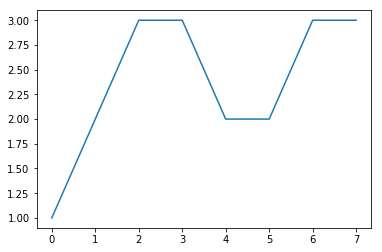

In [13]:
%matplotlib inline
f = [1, 2, 3, 3, 2, 2, 3,3]
plt.plot(f)
plt.show()